# EDA on the HP Character Interation Networks

In [55]:
# import statements
import numpy as np
import networkx as nx
import regex as re 
import os
import matplotlib.pyplot as plt
import pandas as pd
import random 
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patheffects as path_effects
from mpl_toolkits.mplot3d.art3d import Line3DCollection
%matplotlib inline

In [56]:
#read in networks
book_titles = ["The Philosopher's Stone",
              "The Chamber of Secrets",
              "The Prisoner of Azkaban",
              "The Goblet of Fire",
              "The Order of the Phoenix",
              "The Half Blood Prince",
              "The Deathly Hallows"]
fnames = [re.sub("'", '', re.sub(' ', '_', title[4:])) + '_adj_matrix' for title in book_titles]
path = os.getcwd() + '/../adj_matrices/'
A_mats = [np.loadtxt(path + fname) for fname in fnames]

In [65]:
# read in dictionaries
def read_dict(fname):
    path = os.getcwd() + '/../dictionaries/'
    s = open(path + fname, 'r').read()
    d = dict(eval(s))
    return d
    

name_to_id = read_dict('name_to_id')
id_to_name = read_dict('id_to_name')
characters = eval(open(os.getcwd() + '/../dictionaries/characters_list', 'r').read())

list

## Basic EDA

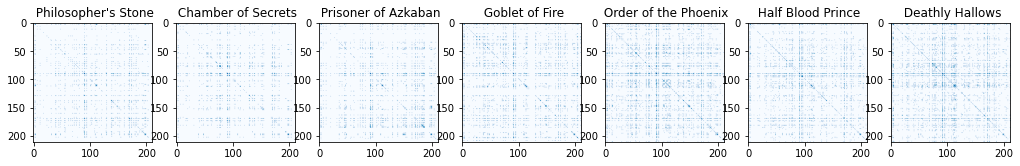

In [4]:
scale = .25;  height = 10; width = height * len(book_titles)
fig, axs = plt.subplots(1, 7, figsize=(scale * width, scale * height))
count = 0
for i in range(len(book_titles)):
    axs[i].imshow(np.log(A_mats[i] + .001), cmap = 'Blues')
    axs[i].set_title(book_titles[i][3:])

In [5]:
import pandas as pd

#Find the x most talked abouct characters by book
x = 10
def top_x(vec):
    return [id_to_name[char_id] for char_id in np.argsort(vec)[-x:][::-1]]


top_characters = [top_x(A_mats[book_id].diagonal()) for book_id in range(len(book_titles))]
pd.DataFrame(np.matrix(top_characters).T, columns = [s[3:] for s in book_titles])

#invert dictionary and print most discussed characters

Philosopher's Stone  Chamber of Secrets  Prisoner of Azkaban  \
0         Harry Potter        Harry Potter         Harry Potter   
1          Ron Weasley         Ron Weasley          Ron Weasley   
2     Hermione Granger    Hermione Granger     Hermione Granger   
3        Rubeus Hagrid    Albus Dumbledore          Remus Lupin   
4     Albus Dumbledore        Fred Weasley         Sirius Black   
5        Severus Snape      George Weasley        Severus Snape   
6   Minerva McGonagall       Rubeus Hagrid        Rubeus Hagrid   
7       Dudley Dursley       Ginny Weasley     Albus Dumbledore   
8   Neville Longbottom  Minerva McGonagall   Minerva McGonagall   
9       Vernon Dursley       Severus Snape          Crookshanks   

            Goblet of Fire  Order of the Phoenix  Half Blood Prince  \
0             Harry Potter          Harry Potter       Harry Potter   
1              Ron Weasley      Hermione Granger   Albus Dumbledore   
2         Hermione Granger           Ron Weasley        Ron Weasley   
3         Albus Dumbledore      Albus Dumbledore   Hermione Granger   
4            Rubeus Hagrid      Dolores Umbridge    Horace Slughorn   
5  Alastor (Mad-Eye) Moody          Fred Weasley      Severus Snape   
6           Cedric Diggory        George Weasley      Ginny Weasley   
7              Viktor Krum         Ginny Weasley     Lord Voldemort   
8             Fred Weasley         Rubeus Hagrid      Rubeus Hagrid   
9           George Weasley    Neville Longbottom       Draco Malfoy   

    Deathly Hallows  
0      Harry Potter  
1  Hermione Granger  
2       Ron Weasley  
3  Albus Dumbledore  
4    Lord Voldemort  
5     Severus Snape  
6     Rubeus Hagrid  
7     Ginny Weasley  
8       Remus Lupin  
9     Luna Lovegood

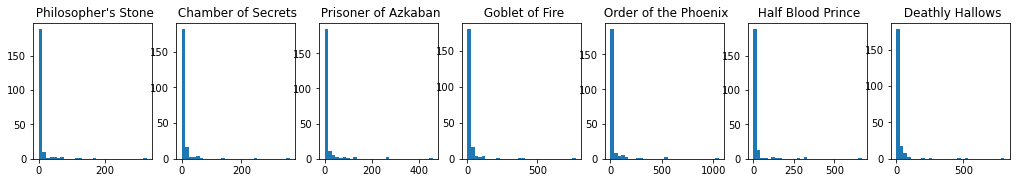

In [6]:
#check out degree distributions
scale = .25;  height = 10; width = height * len(book_titles)
fig, axs = plt.subplots(1, 7, figsize=(scale * width, scale * height))
count = 0
for i in range(len(book_titles)):
    axs[i].set_title(book_titles[i][3:])
    axs[i].hist(A_mats[i].diagonal(), density=False, bins=30)

Incredibly right skewed - maybe not so surpising. Let's look at the log transform of these values.

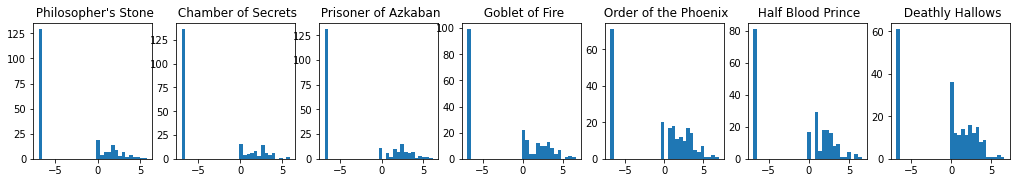

In [7]:
#check out degree distributions
scale = .25;  height = 10; width = height * len(book_titles)
fig, axs = plt.subplots(1, 7, figsize=(scale * width, scale * height))
count = 0
for i in range(len(book_titles)):
    axs[i].set_title(book_titles[i][3:])
    axs[i].hist(np.log(A_mats[i].diagonal() + 0.001), density=False, bins=30)

Several isolates - again not that surprising. Should serve as an interesting question for how/when do we embed these networks. 

In [8]:
def get_sparsity(M):
    mask = M[np.triu_indices(M.shape[0])] > 0
    return np.round(sum(mask) / len(mask), 4)

[get_sparsity(A) for A in A_mats]

[0.0368, 0.0338, 0.0438, 0.0646, 0.0946, 0.0674, 0.0909]

Networks are also quite sparse which may pose an issue later down the line.

## Visualize Networks

In [9]:
graphs = [nx.from_numpy_matrix(A) for A in A_mats]
abar_graph = nx.from_numpy_matrix(sum(A_mats) / len(A_mats))

In [38]:
def delete_row_column(M, ind_list):
    mat = M.copy()
    mat = np.delete(mat, ind_list, 0)
    mat = np.delete(mat, ind_list, 1)
    return(mat)

def plot_top_x(A, x, size_scale = 1, title = '', save = False):
    #get top x most active characters
    inds_to_keep = np.argsort(A.diagonal())[-x:]
    inds_to_delete = np.argsort(A.diagonal())[:-x]
    
    #make labels_dict
    character_subset = [id_to_name[inds_to_keep[i]] for i in range(x)]
    character_subset.sort()
    labels_dict = {}
    for i in range(x): # 
        labels_dict[i] = '\n'.join(character_subset[i].split())
   
    #get sub matrix and make networkx object
    A_sub = delete_row_column(A, inds_to_delete)
    G = nx.from_numpy_matrix(A_sub)
    
    #get node sizes 
    degree = np.sqrt(A_sub.diagonal())
    node_size = (degree - min(degree)) / (np.max(degree) - np.min(degree))
    
    #set edge widths
    weights = [np.sqrt(G[u][v]['weight']) for u,v in G.edges]
    weights = (weights - np.min(weights)) / (np.max(weights) - np.min(weights))

    #plot figure
    fig = plt.figure(figsize=(size_scale,size_scale))
    plt.title(title, fontsize = size_scale * 2)
    pos = nx.fruchterman_reingold_layout(G)
    nx.draw(G, pos = pos, 
            labels = labels_dict, with_lable = True, alpha = 0.5, 
            node_size = size_scale * 200 * node_size, font_size = size_scale,
            edge_color = 'gray', width = size_scale * 0.25 * weights, edge_cmap = plt.cm.Greys)
    
    #save figure and plot
    if save == True:
        path = '../figures/' + re.sub(' ', '_', re.sub("'", '',title[4:])) + '.png'
        plt.savefig(path, dpi=425,bbox_inches='tight')
    else:
        plt.show()

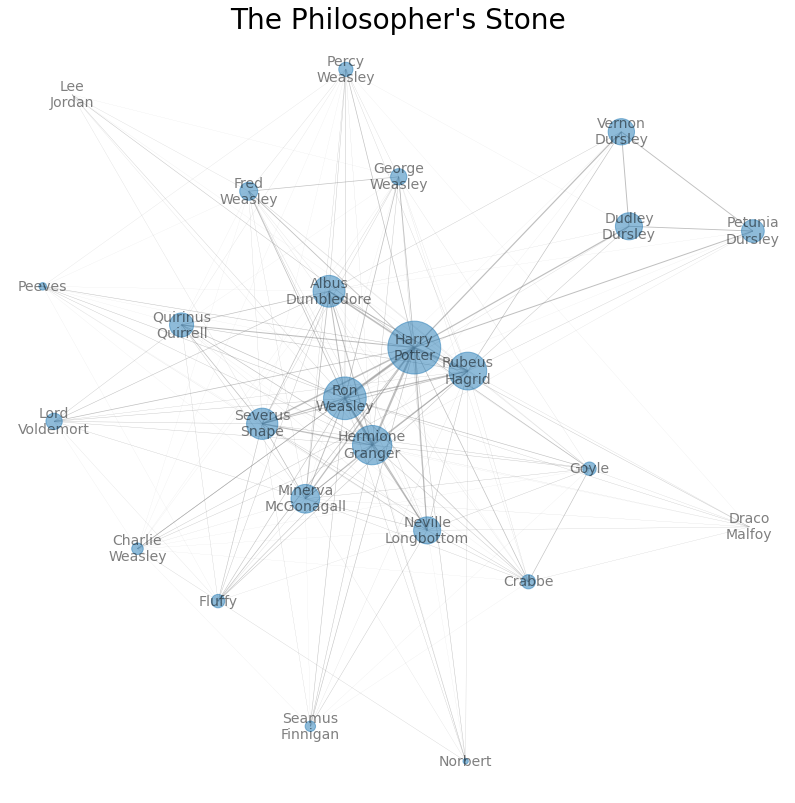

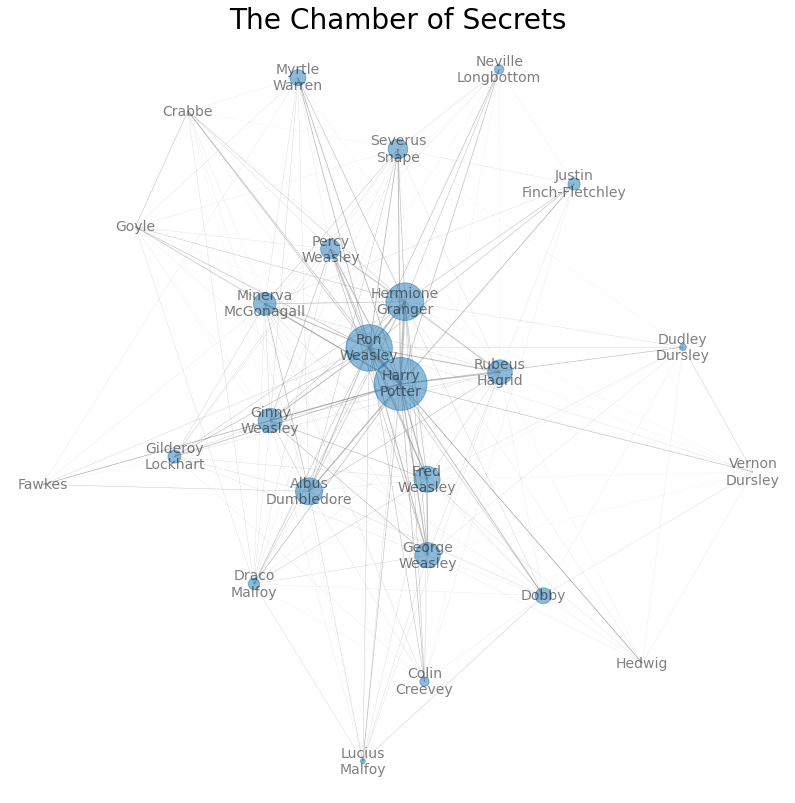

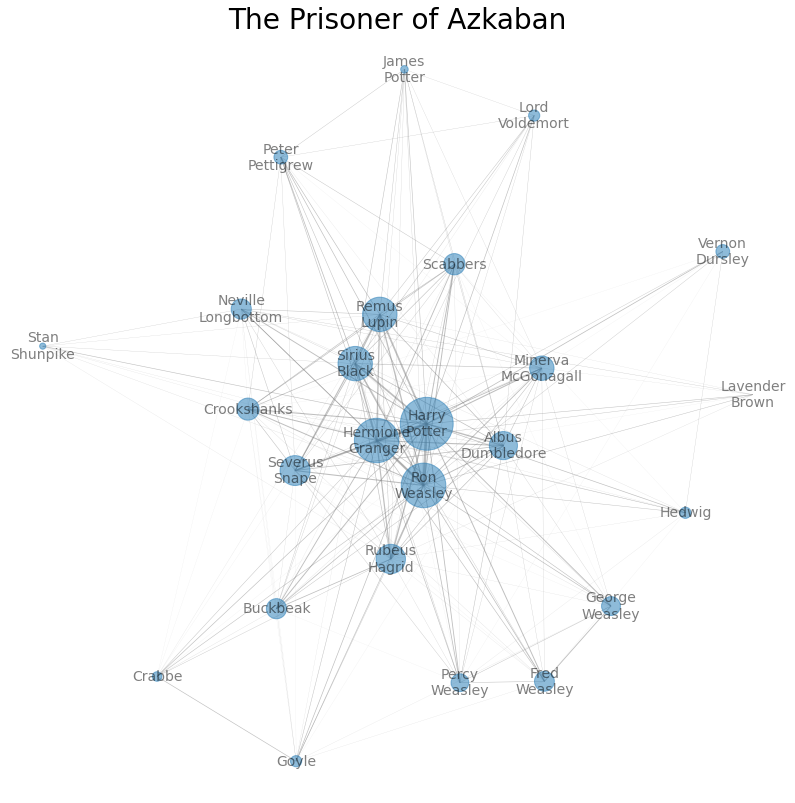

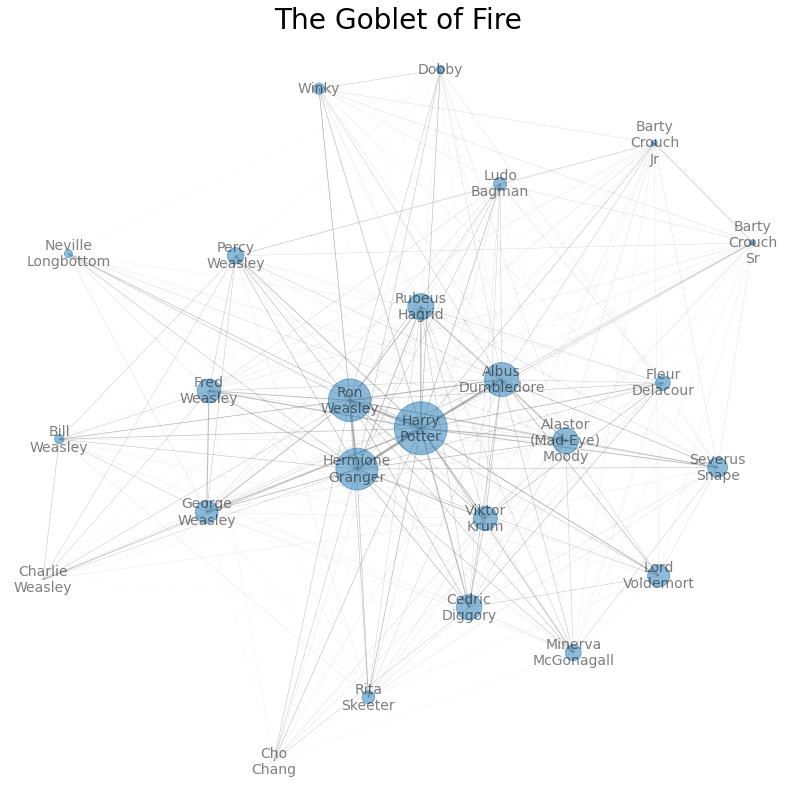

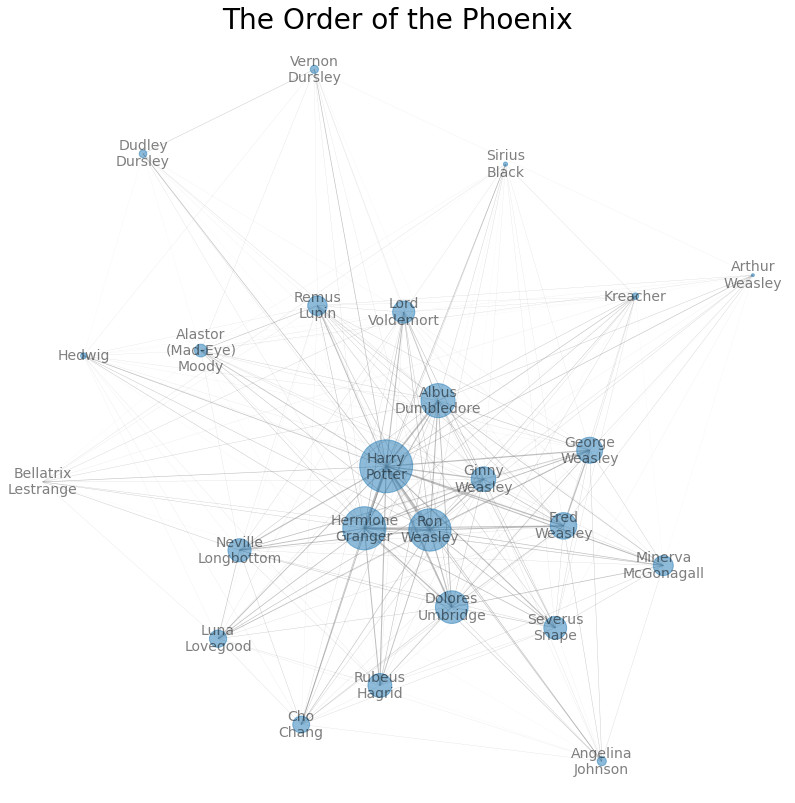

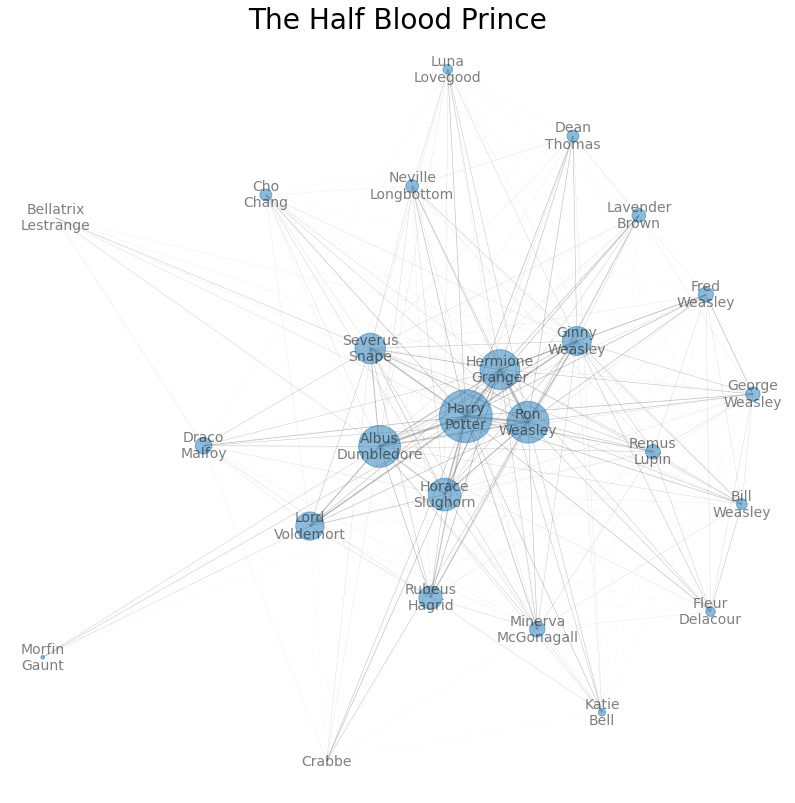

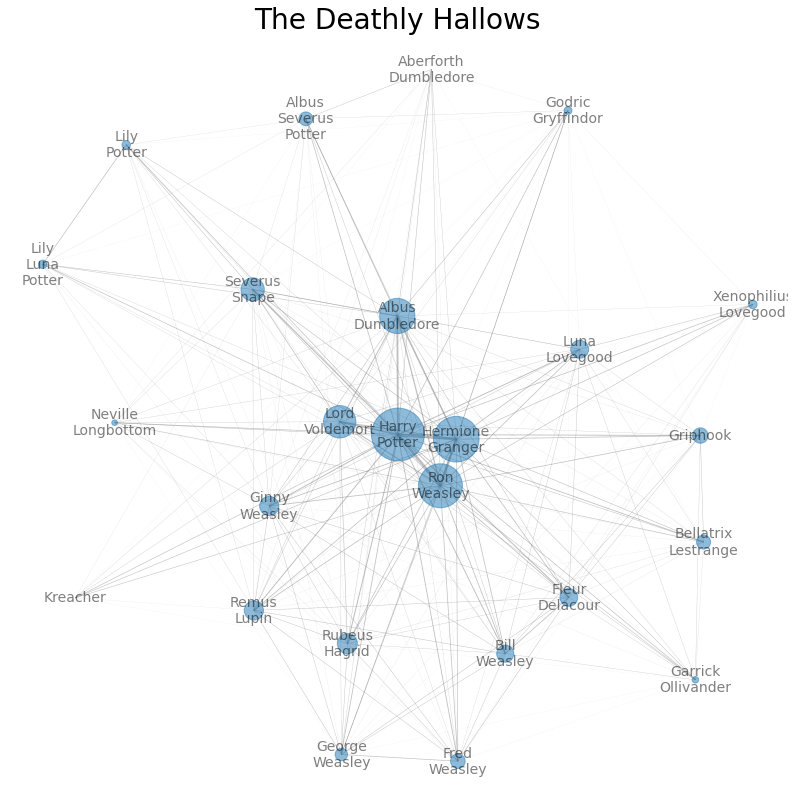

In [39]:
#plot different books
random.seed(1985)
for i in range(len(book_titles)):
    plot_top_x(A_mats[i], 25, size_scale = 14, title = book_titles[i], save = True)

## Multiplex Network Visualization

In [180]:
#subset to only core component
ids_to_keep = []
for i in range(len(characters)):
    degs = np.array([A[i,i] for A in A_mats])
    if np.min(degs) > 0: 
        ids_to_keep += [i]

#get new set of adjcancey matrices
A_mats_cc = [A[:, ids_to_keep][ids_to_keep, :] for A in A_mats]        
        
#create networkx objects
graphs = [nx.from_numpy_matrix(A) for A in A_mats_cc]
pos = nx.fruchterman_reingold_layout(graphs[4])
cols = ['pink','orange','red', 'darkcyan', 'green', 'blue', 'purple']
layer_names = ['\n'.join(title[4:].split()) for title in book_titles]

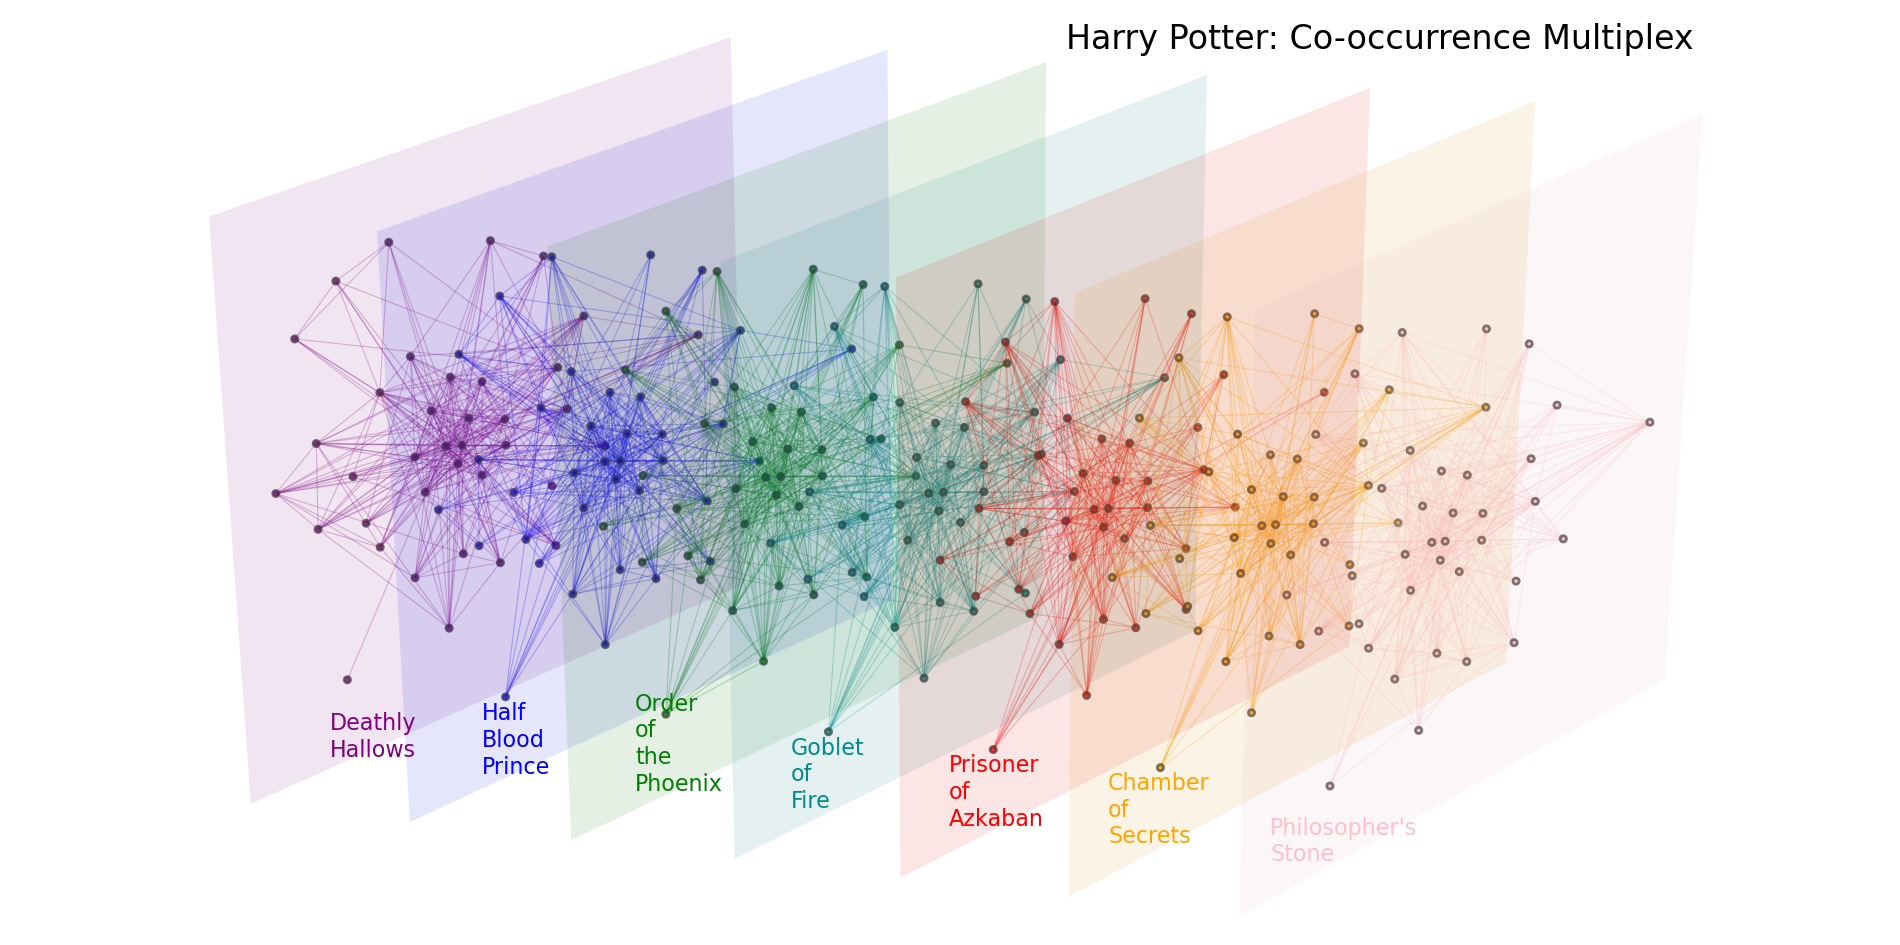

In [181]:
h = 6; w = 2*h
fig, ax = plt.subplots(1, 1, figsize=(w,h), dpi=200, subplot_kw={'projection':'3d'})
random.seed(1985)

for gi, G in enumerate(graphs):
    # set node positions
    ys = list(list(zip(*list(pos.values())))[0])
    zs = list(list(zip(*list(pos.values())))[1])
    xs = [gi]*len(ys) # set a common x-position of the nodes 
    
    # node colors
    cs = [cols[gi]]*len(xs)
    
    # add within-layer edges
    lines3d = [([gi]+list(pos[j]) , [gi]+list(pos[i])) for i,j in G.edges()]
    line_collection = Line3DCollection(lines3d, zorder=gi, color=cols[gi], alpha=.25, linewidths = .4)
    ax.add_collection3d(line_collection)
    
    # now add nodes
    ax.scatter(xs, ys, zs, c=cs, s = 5, edgecolors='.25', marker='o', alpha=.75, zorder=gi)
    
    # add a plane to designate the layer    
    zdiff = max(zs)-min(zs)
    ydiff = max(ys)-min(ys)
    ymin = min(ys)-ydiff*0.1
    ymax = max(ys)+ydiff*0.1
    zmin = min(zs)-zdiff*0.1 * (w/h)
    zmax = max(zs)+zdiff*0.1 * (w/h)
    zz, yy = np.meshgrid([zmin, zmax],[ymin, ymax])
    xx = np.zeros(zz.shape)+gi
    ax.plot_surface(xx, yy, zz, color=cols[gi], alpha=0.1, zorder=gi)
    
    # add label
    layertext = ax.text(gi*0.95, 0.7, -0.8, layer_names[gi], 
                        color=cols[gi], fontsize=8, zorder=1e5)

# set them all at the same x,y,zlims
ax.set_xlim(-0.1, len(graphs) - 1 + 0.1)
ax.set_ylim(min(ys)-ydiff*0.1,max(ys)+ydiff*0.1)
ax.set_zlim(min(zs)-zdiff*0.1,max(zs)+zdiff*0.1)


# select viewing angle
angle = 115
height_angle = 25
ax.view_init(height_angle, angle)

# how much do you want to zoom into the fig
ax.dist = 9
ax.set_axis_off()
ax.set_title('Harry Potter: Co-occurrence Multiplex', loc = 'right', y = 0.95, x = 0.9)

#save figure - png
plt.savefig('../figures/harry_potter_multiplex_network.png',dpi=425,bbox_inches='tight')
plt.show()

#save figure - pdf
#plt.savefig('../figures/aarhus_multiplex_network.pdf', dpi=425,bbox_inches='tight')
plt.show()

## Visualize Networks in one figure

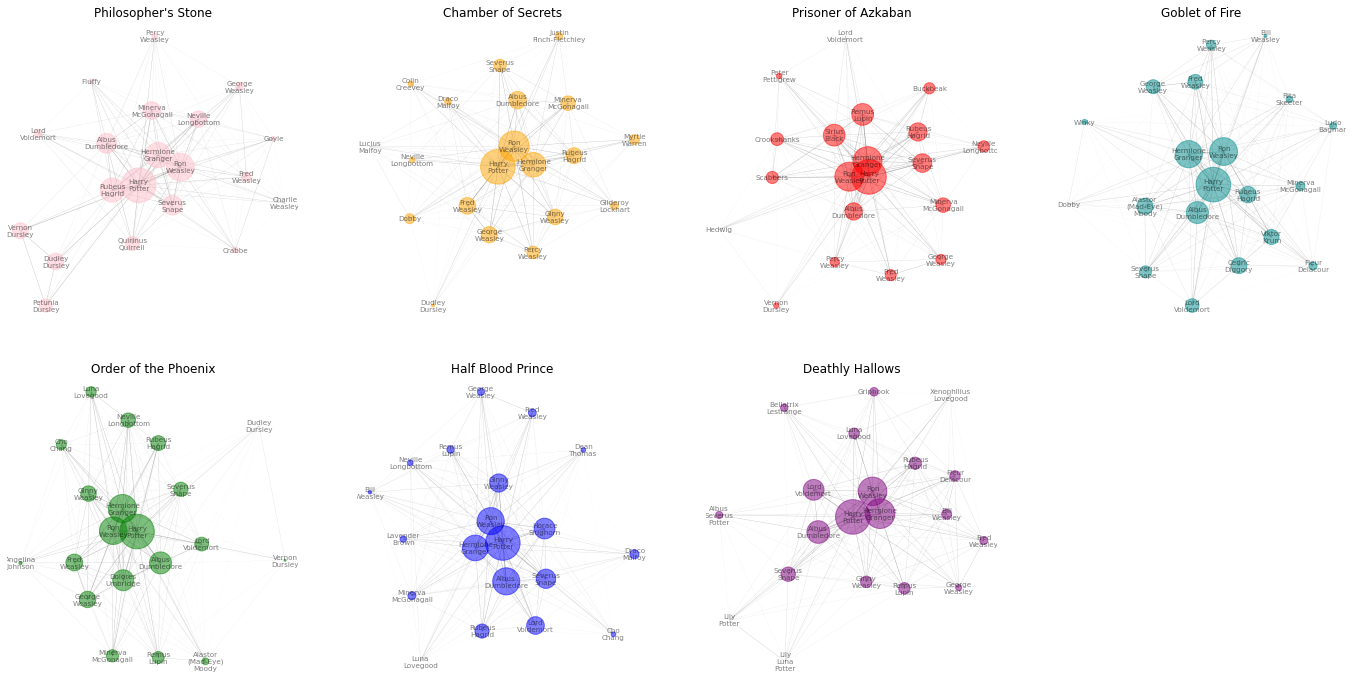

In [196]:
# rendering
random.seed(1985)
nr = 2; nc = 4
size_scale = 6; x = 20
fig, ax = plt.subplots(nr, nc, num=1, figsize=(nc * size_scale, nr * size_scale)) 

for i, A in enumerate(A_mats):
    #get top x most active characters
    inds_to_keep = np.argsort(A.diagonal())[-x:]
    inds_to_delete = np.argsort(A.diagonal())[:-x]
    
    #make labels_dict
    character_subset = [id_to_name[inds_to_keep[i]] for i in range(x)]
    character_subset.sort()
    labels_dict = {}
    for j in range(x): # 
        labels_dict[j] = '\n'.join(character_subset[j].split())
   
    #get sub matrix and make networkx object
    A_sub = delete_row_column(A, inds_to_delete)
    G = nx.from_numpy_matrix(A_sub)
    
    #get node sizes 
    degree = np.sqrt(A_sub.diagonal())
    node_size = (degree - min(degree)) / (np.max(degree) - np.min(degree))
    
    #set edge widths
    weights = [np.sqrt(G[u][v]['weight']) for u,v in G.edges]
    weights = (weights - np.min(weights)) / (np.max(weights) - np.min(weights))

    #plot figure
    ix = np.unravel_index(i, ax.shape)    
    plt.sca(ax[ix])
    pos = nx.fruchterman_reingold_layout(G)
    nx.draw(G, pos = pos, ax=ax[ix], 
            labels = labels_dict, with_lable = True, alpha = 0.5, 
            node_size = size_scale * 200 * node_size, font_size = 1.2 * size_scale, node_color = cols[i],
            edge_color = 'gray', width = size_scale * 0.25 * weights, edge_cmap = plt.cm.Greys)
    plt.title(book_titles[i][4:])
    
#Delete extra axes
fig.delaxes(ax[nr-1][nc-1])
#fig.delaxes(ax[nr-1][nc-2])

#save - png
plt.savefig('../figures/harry_potter_multiplex_flattened.png',dpi=425,bbox_inches='tight')
plt.show()

#save - pdf
#plt.savefig('../figures/harry_potter_multiplex_flattened.pdf',dpi=425,bbox_inches='tight')
#plt.show()